![](../assets/DJlogo_alpha.png?raw=true)<!-- .element height="80%" width="80%" -->


# QR decomposition
### Author: Peter Hurley
This notebook will cover QR decomposition

The covariates in regression models can often have strong correlations and these will propagate themselves in the posterior probability distribution.

For example:
* Polynomial regression
* independent covariates (i.e. conditionally independent given unknown confounders)
**Can you think of any examples?** 

These correlations can be problematic when computing the posterior. QR decomposition is a way of decorrelating the covariates such that the posterior can be accurately estimated. 

## Example: linear regression

In [1]:
import pylab as plt
import numpy as np
import pystan
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
# set seed for numpy
np.random.seed(29111986)

In [3]:
N=5000
x=np.random.normal(10,1,N)

In [4]:
X=np.matrix(np.vstack((x,x**2))).T

In [34]:
X.shape

(5000, 2)

In [8]:
M=2
beta = np.matrix(np.array([2.5, -1])).T
alpha = -0.275
sigma = 0.8

In [6]:
mu=X*beta+alpha
y=np.random.normal(mu,sigma)

Because the covariate $x$ is restricted to positive values, it is highly correlated with its square,



Text(0, 0.5, '$x^2$')

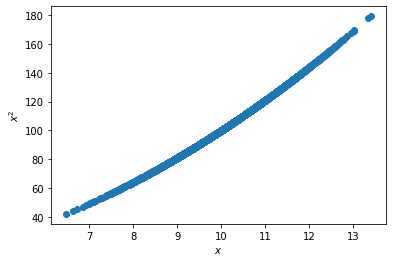

In [7]:
plt.plot(X[:,0],X[:,1], 'o')
plt.xlabel(r'$x$')
plt.ylabel(r'$x^2$')

With the data in hand we can attempt to fit a naive linear regression model with Stan, making sure we carry out all the normal diagnostic checks.



In [9]:
model="""data {
  int<lower=1> N;
  int<lower=1> M;
  matrix[M, N] X;
  vector[N] y;
}

parameters {
  vector[M] beta;
  real alpha;
  real<lower=0> sigma;
}

model {
  beta ~ normal(0, 10);
  alpha ~ normal(0, 10);
  sigma ~ cauchy(0, 10);

  y ~ normal(X' * beta + alpha, sigma);
}
"""

In [10]:
simp_model=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_68f3b2ebd9e5745c50f64e06132c7f89 NOW.


In [11]:
data={
    'N':N,
    'M':M,
    'X':X.T,
    'y':y.flatten()
}

In [12]:
fit=simp_model.sampling(data=data,iter=1000,chains=4, seed=29111986)

In [13]:
fit

Inference for Stan model: anon_model_68f3b2ebd9e5745c50f64e06132c7f89.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]    2.5    0.01   0.15   2.21    2.4   2.51    2.6   2.82    192   1.02
beta[2]   -1.0  5.6e-4 7.8e-3  -1.02   -1.0   -1.0  -0.99  -0.98    194   1.02
alpha     -0.4    0.06   0.77  -2.01  -0.88  -0.43   0.08   1.08    191   1.02
sigma      0.8  2.5e-4 7.4e-3   0.78   0.79    0.8    0.8   0.81    861    1.0
lp__     -1378    0.05   1.27  -1381  -1378  -1377  -1377  -1376    607    1.0

Samples were drawn using NUTS at Fri Jul 31 12:44:30 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [14]:
pystan.diagnostics.check_hmc_diagnostics(fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': False,
 'energy': True}

There are some iterations that are saturating the maximum tree depth, indicating there could be a bit of a problem.

In [15]:
samp_params=fit.get_sampler_params(inc_warmup=False)

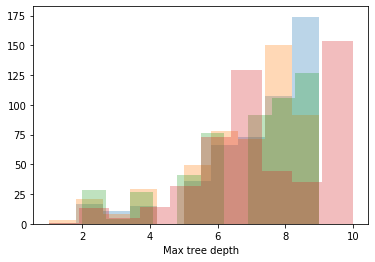

In [16]:
for i in range(0,4):
    plt.hist(samp_params[i]['treedepth__'],alpha=0.3)
plt.xlabel('Max tree depth');

In [17]:
for i in range(0,4):
    print('Number of gradient evaluations for chain '+str(i+1),samp_params[i]['n_leapfrog__'].sum())

Number of gradient evaluations for chain 1 186106.0
Number of gradient evaluations for chain 2 147342.0
Number of gradient evaluations for chain 3 159764.0
Number of gradient evaluations for chain 4 232252.0


Even a few prematurely terminating trajectories can hinder performance, and may even indicate potential problems with adaptation.

To maximize performance and avoid any potential issues we refit with a larger tree depth threshold,

In [18]:
fit=simp_model.sampling(data=data,iter=1000,chains=4, control=dict(max_treedepth=15),seed=29111986, verbose=True)

In [19]:
fit

Inference for Stan model: anon_model_68f3b2ebd9e5745c50f64e06132c7f89.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]   2.53  7.9e-3   0.16   2.21   2.43   2.54   2.64   2.84    405    1.0
beta[2]   -1.0  3.9e-4 7.9e-3  -1.02  -1.01   -1.0   -1.0  -0.98    408    1.0
alpha    -0.57    0.04   0.79  -2.12  -1.11  -0.57  -0.06    1.0    405    1.0
sigma      0.8  3.0e-4 8.1e-3   0.78   0.79    0.8    0.8   0.82    700    1.0
lp__     -1378    0.05   1.32  -1381  -1378  -1377  -1377  -1376    702    1.0

Samples were drawn using NUTS at Fri Jul 31 12:55:55 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [20]:
pystan.diagnostics.check_hmc_diagnostics(fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

There is still an issue with the tree depth being maxed and chains behaving erraticly, as can be seen in figure below

In [21]:
samp_params=fit.get_sampler_params(inc_warmup=False)

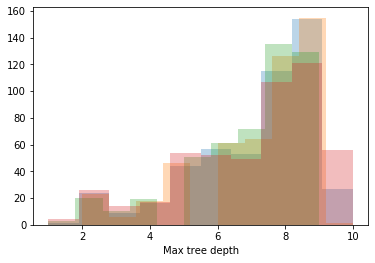

In [22]:
for i in range(0,4):
    plt.hist(samp_params[i]['treedepth__'],alpha=0.3)
plt.xlabel('Max tree depth');

In [23]:
for i in range(0,4):
    print('Number of gradient evaluations for chain '+str(i+1),samp_params[i]['n_leapfrog__'].sum())

Number of gradient evaluations for chain 1 198662.0
Number of gradient evaluations for chain 2 174184.0
Number of gradient evaluations for chain 3 159608.0
Number of gradient evaluations for chain 4 200862.0


## The details of QR decomposition

The correlation between the covariates ($x$ and $x^2$ in our example) is high and this causes a very tight correlation in the  coefficients in the linear model, which in turn leads to a posterior which is challenging to explore. QR helps elleviate this problem by reducing the correlation between the covariates. It arises in the analytic maximum likelihood and conjugate Bayesian treatment of linear regression, although here it will be applicable regardless of the choice of priors and for any general linear model.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


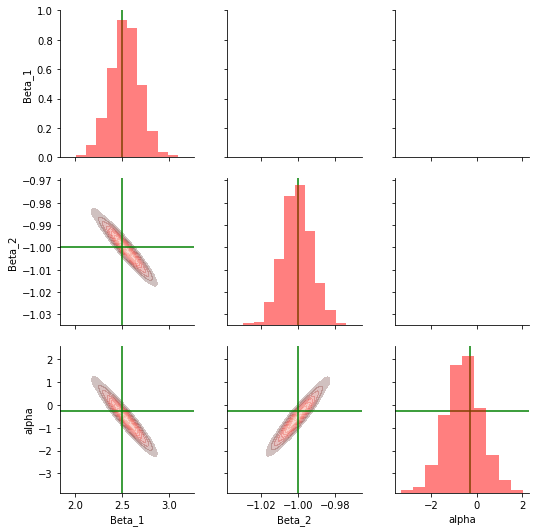

In [24]:
g=sns.PairGrid(pd.DataFrame(np.hstack((fit['beta'],fit['alpha'].reshape(2000,1))),columns=['Beta_1','Beta_2','alpha']))
g.map_lower(sns.kdeplot,shade=True,shade_lowest=False,cmap="Reds_d",alpha=0.3,n_levels=10,normed=True)
g.map_diag(plt.hist,color='red',alpha=0.5)
for i in range(0,3):
    for j in range(1,3):
        if (j>i) and (j<2):
            g.axes[j,i].axvline(beta[i,0],c='green')
            g.axes[j,i].axhline(beta[j,0],c='green')
        if j ==2:
            g.axes[j,i].axhline(alpha,c='green')
            if i < 2:
                g.axes[j,i].axvline(beta[i,0],c='green')
    if i<2:
        g.axes[i,i].axvline(beta[i,0],c='green')
    if i==2:
        g.axes[i,i].axvline(alpha,c='green')

## Maths derivation 

The principle is to decompose a rectangular $N \times M$ matrix, A such that:

$$\mathbf{A} = \mathbf{Q} \cdot \mathbf{R} $$
 * N = number of data points
 * M = number of covariates
 * $\mathbf{Q}$ is $N \times M$ orthogonal matrix
 * $\mathbf{R}$ is an $M \times M$ upper triangular matrix

![](./assets/EngMath_Matrix_QRDecomposition_02.png)

Our linear regression model is:
    $$ \mathbf{\mu} = \mathbf{X}^{T} \cdot \boldsymbol{\beta} + \alpha$$
    
Apply QR decomposition to $ \mathbf{X}^{T}$ (the matrix which has correlated covariates):
$$\mathbf{\mu} = \mathbf{Q} \cdot \mathbf{R} \cdot \boldsymbol{\beta} + \alpha$$
$$\mathbf{\mu} = \mathbf{Q} \cdot (\mathbf{R} \cdot \boldsymbol{\beta}) + \alpha$$
$$\mathbf{\mu} = \mathbf{Q} \cdot \widetilde{\boldsymbol{\beta}} + \alpha$$

It is also a good idea to normalise $\mathbf{Q}$ and $\mathbf{R}$ so to equalise the scales of the posterior.

$$\mathbf{Q^*}=\mathbf{Q}\sqrt{N - 1}$$
$$\mathbf{R^\ast} = \frac{1}{\sqrt{N - 1}} \mathbf{R}$$
We treat $\widetilde{\boldsymbol{\beta}}$ as our parameter in the Stan model. Because $\mathbf{Q}$ is orthogonal, its covariates are no longer correlated and hence the posterior on $\widetilde{\boldsymbol{\beta}}$ should be less correlated.

**Less correlation = Markov chain finds it easier to explore** 

To can get back our original $\boldsymbol{\beta}$:
$$\boldsymbol{\beta} = \beta = R^{\ast^{-1}} \widetilde{\boldsymbol{\beta}}$$

### How do we calculate Q and R?
Several methods for computing the QR decomposition: 
* the Gram–Schmidt process
* Householder transformations
* Givens rotations

Well known linear algebra problem, i.e. algorithms are in `numpy`

In [26]:
q, r = np.linalg.qr(X)
q=q*np.sqrt(X.shape[0]-1)
r=r/np.sqrt(X.shape[0]-1)

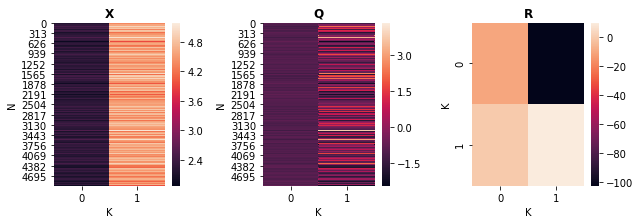

In [28]:
fig,axes=plt.subplots(1,3,figsize=(10,3))
sns.heatmap(np.log(X),ax=axes[0])
axes[0].set_xlabel('K')
axes[0].set_ylabel('N')
axes[0].set_title('$\mathbf{X}$')
sns.heatmap(q,ax=axes[1])
axes[1].set_xlabel('K')
axes[1].set_ylabel('N')
axes[1].set_title('$\mathbf{Q}$')
sns.heatmap(r,ax=axes[2])
axes[2].set_xlabel('K')
axes[2].set_ylabel('K')
axes[2].set_title('$\mathbf{R}$')
plt.subplots_adjust(wspace=0.5)


Text(0.5, 1.0, '$\\mathbf{Q}$')

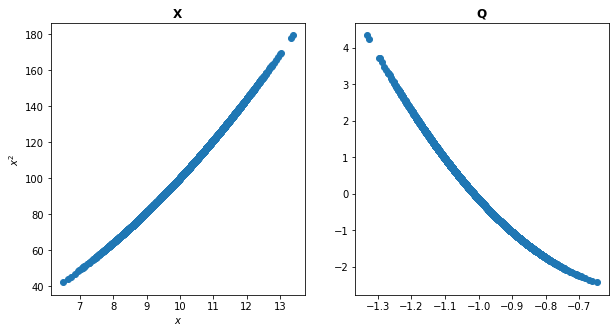

In [29]:
fig,axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(X[:,0],X[:,1],'o')
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$x^2$')
axes[0].set_title('$\mathbf{X}$')
axes[1].plot(q[:,0],q[:,1],'o')
axes[1].set_title('$\mathbf{Q}$')


In [30]:
print(r'$\rho$ for X = {} , $\rho$ for q = {}'.format(np.corrcoef(X.T)[0,1],np.corrcoef(q.T)[0,1]))

$\rho$ for X = 0.9976131840699471 , $\rho$ for q = -0.9901937770974361


<h2>Mathematical Derivation</h2>
<p>The <em>thin</em> QR decomposition decomposes a rectangular <span class="math inline">\(N \times M\)</span> matrix into <span class="math display">\[
\mathbf{A} = \mathbf{Q} \cdot \mathbf{R}
\]</span> where <span class="math inline">\(\mathbf{Q}\)</span> is an <span class="math inline">\(N \times M\)</span> orthogonal matrix with <span class="math inline">\(M\)</span> non-zero rows and <span class="math inline">\(N - M\)</span> rows of vanishing rows, and <span class="math inline">\(\mathbf{R}\)</span> is a <span class="math inline">\(M \times M\)</span> upper-triangular matrix.</p>
<p>If we apply the decomposition to the transposed design matrix, <span class="math inline">\(\mathbf{X}^{T} = \mathbf{Q} \cdot \mathbf{R}\)</span>, then we can refactor the linear response as <span class="math display">\[
\begin{align*}
\boldsymbol{\mu}
&= \mathbf{X}^{T} \cdot \boldsymbol{\beta} + \alpha
\\
&= \mathbf{Q} \cdot \mathbf{R} \cdot \boldsymbol{\beta} + \alpha
\\
&= \mathbf{Q} \cdot (\mathbf{R} \cdot \boldsymbol{\beta}) + \alpha
\\
&= \mathbf{Q} \cdot \widetilde{\boldsymbol{\beta}} + \alpha.
\\
\end{align*}
\]</span></p>
<p>Because the matrix <span class="math inline">\(\mathbf{Q}\)</span> is orthogonal, its columns are independent and consequently we expect the posterior over the new parameters, <span class="math inline">\(\widetilde{\boldsymbol{\beta}} = \mathbf{R} \cdot \boldsymbol{\beta}\)</span>, to be significantly less correlated. In practice we can also equalize the scales of the posterior by normalizing the <span class="math inline">\(Q\)</span> and <span class="math inline">\(R\)</span> matrices, <span class="math display">\[
\begin{align*}
\mathbf{Q} &;\rightarrow \mathbf{Q} \cdot N
\\
\mathbf{R} &;\rightarrow \mathbf{R} \, / \, N.
\end{align*}
\]</span></p>
<p>We can then readily recover the original slopes as <span class="math display">\[
\boldsymbol{\beta} = \mathbf{R}^{-1} \cdot \widetilde{\boldsymbol{\beta}}.
\]</span> As <span class="math inline">\(\mathbf{R}\)</span> is upper diagonal we could compute its inverse with only <span class="math inline">\(\mathcal{O} (M^{2})\)</span> operations, but because we need to compute it only once we will use the naive inversion function in Stan here.</p>
<p>Because the transformation between <span class="math inline">\(\boldsymbol{\beta}\)</span> and <span class="math inline">\(\widetilde{\boldsymbol{\beta}}\)</span> is <em>linear</em>, the corresponding Jacobian depends only on the data and hence doesn’t affect posterior computations. This means that in Stan we can define the transformed parameters <span class="math inline">\(\boldsymbol{\beta} = \mathbf{R}^{-1} \cdot \widetilde{\boldsymbol{\beta}}\)</span> and apply priors directly to <span class="math inline">\(\boldsymbol{\beta}\)</span> while ignoring the warning about Jacobians.</p>
<p>Interestingly, applying weakly-informative priors to the <span class="math inline">\(\widetilde{\boldsymbol{\beta}}\)</span> directly can be interpreted as a form of <em>empirical Bayes</em>, where we use the empirical correlations in the data to guide the choice of prior.</p>
</div>

## Scaled QR decomposition in Stan

In [32]:
qr_model="""

data {
  int<lower=0> N;   // number of data items
  int<lower=0> M;   // number of predictors
  matrix[M, N] X;   // predictor matrix
  vector[N] y;      // outcome vector
}
transformed data {
  matrix[N, M] Q_ast;
  matrix[M, M] R_ast;
  matrix[M, M] R_ast_inverse;
  // thin and scale the QR decomposition
  Q_ast = qr_thin_Q(X') * sqrt(N - 1);
  R_ast = qr_thin_R(X') / sqrt(N - 1);
  R_ast_inverse = inverse(R_ast);
}
parameters {
  real alpha;           // intercept
  vector[M] beta_tilde;      // coefficients on Q_ast
  real<lower=0> sigma;  // error scale
}

transformed parameters {
 vector[M] beta;
  beta = R_ast_inverse * beta_tilde; // coefficients on X
}
model {
  beta ~ normal(0, 10);
  alpha ~ normal(0, 10);
  sigma ~ cauchy(0, 10);
  y ~ normal(Q_ast * beta_tilde + alpha, sigma);  // liMelihood
}
"""

In [33]:
qr_model=pystan.StanModel(model_code=qr_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c639dd6046779e6b2c193820099d40dd NOW.


In [36]:
fit_qr=qr_model.sampling(data=data,chains=4,iter=1000)

In [37]:
fit_qr

Inference for Stan model: anon_model_c639dd6046779e6b2c193820099d40dd.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                mean se_mean     sd   2.5%    25%    50%     75%  97.5%  n_eff   Rhat
alpha          -0.54    0.04   0.81  -2.05  -1.08  -0.58 -6.9e-3   1.08    338   1.01
beta_tilde[1]  -77.0    0.04    0.8  -78.6 -77.53 -76.95  -76.46 -75.49    338   1.01
beta_tilde[2]  -9.88  4.4e-3   0.08 -10.03  -9.93  -9.88   -9.83  -9.72    328   1.01
sigma            0.8  3.3e-4 8.3e-3   0.78   0.79    0.8     0.8   0.82    628   1.01
beta[1]         2.53  8.9e-3   0.16    2.2   2.42   2.53    2.63   2.83    331   1.01
beta[2]         -1.0  4.4e-4 8.0e-3  -1.02  -1.01   -1.0   -0.99  -0.98    328   1.01
lp__           -1378    0.07   1.43  -1381  -1378  -1377   -1377  -1376    468   1.01

Samples were drawn using NUTS at Fri Jul 31 13:18:17 2020.
For each parameter, n_eff is a crude measure of effective sample 

Already we can see that there are more effective samples. Lets check the other diagnostics

In [38]:
pystan.diagnostics.check_hmc_diagnostics(fit_qr)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

We are no longer saturating maximum tree depth. Lets check tree depth graph and number of gradient evaluations.

In [39]:
samp_params=fit_qr.get_sampler_params(inc_warmup=False)

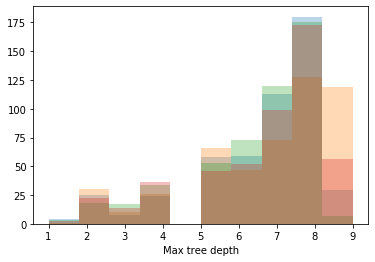

In [40]:
for i in range(0,4):
    plt.hist(samp_params[i]['treedepth__'],alpha=0.3)
plt.xlabel('Max tree depth');

In [41]:
for i in range(0,4):
    print('Number of gradient evaluations for chain '+str(i+1),samp_params[i]['n_leapfrog__'].sum())

Number of gradient evaluations for chain 1 112042.0
Number of gradient evaluations for chain 2 135870.0
Number of gradient evaluations for chain 3 98896.0
Number of gradient evaluations for chain 4 119850.0


in the QR decomposition we require only about half the gradient evaluations needed in the naive regression.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


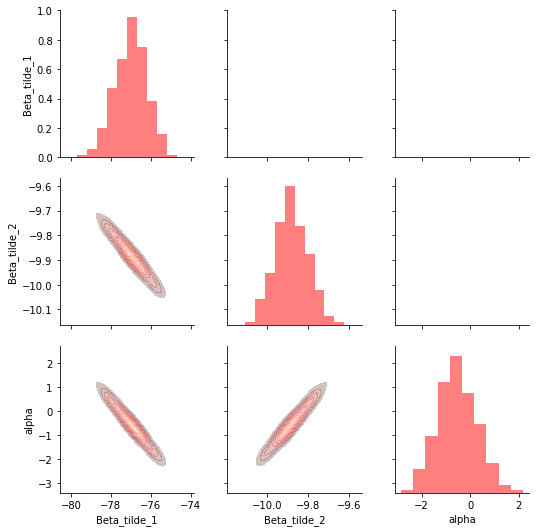

In [42]:
g=sns.PairGrid(pd.DataFrame(np.hstack((fit_qr['beta_tilde'],fit_qr['alpha'].reshape(2000,1))),columns=['Beta_tilde_1','Beta_tilde_2','alpha']))
g.map_lower(sns.kdeplot,shade=True,shade_lowest=False,cmap="Reds_d",alpha=0.3,n_levels=10,normed=True)
g.map_diag(plt.hist,color='red',alpha=0.5)


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


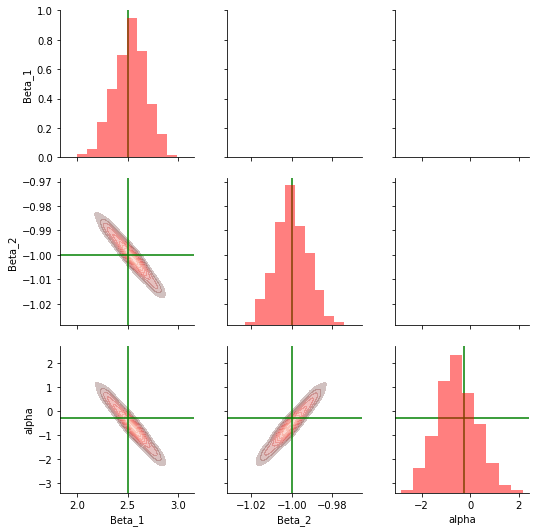

In [43]:
g=sns.PairGrid(pd.DataFrame(np.hstack((fit_qr['beta'],fit_qr['alpha'].reshape(2000,1))),columns=['Beta_1','Beta_2','alpha']))
g.map_lower(sns.kdeplot,shade=True,shade_lowest=False,cmap="Reds_d",alpha=0.3,n_levels=10,normed=True)
g.map_diag(plt.hist,color='red',alpha=0.5)
for i in range(0,3):
    for j in range(1,3):
        if (j>i) and (j<2):
            g.axes[j,i].axvline(beta[i,0],c='green')
            g.axes[j,i].axhline(beta[j,0],c='green')
        if j ==2:
            g.axes[j,i].axhline(alpha,c='green')
            if i < 2:
                g.axes[j,i].axvline(beta[i,0],c='green')
    if i<2:
        g.axes[i,i].axvline(beta[i,0],c='green')
    if i==2:
        g.axes[i,i].axvline(alpha,c='green')



### Centering Covariates

$\widetilde{\boldsymbol{\beta}}$ is still quite correlated. We also saw that the covariates were still very correlated with each other when carrying out the qr decomposition with numpy.

Fully decorrelating the covariates requires centering (i.e. mean subtract). 

**NOTE:**
If we do this, remember the intercept no longer has the same interpretation and needs to be transformed:
$$\alpha=\widetilde{\alpha}-\overline{\mathbf{X}^{T}} \cdot \boldsymbol{\beta}$$


In [44]:
q, r = np.linalg.qr(X-np.mean(X,axis=0))
q=q*np.sqrt(X.shape[0]-1)
r=r/np.sqrt(X.shape[0]-1)

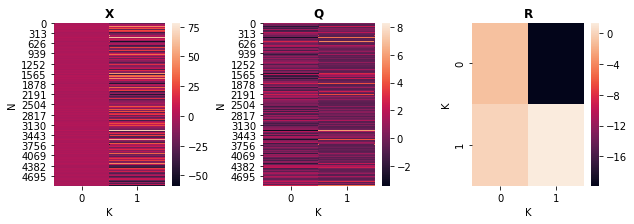

In [45]:
fig,axes=plt.subplots(1,3,figsize=(10,3))
sns.heatmap(X-np.mean(X,axis=0),ax=axes[0])
axes[0].set_xlabel('K')
axes[0].set_ylabel('N')
axes[0].set_title('$\mathbf{X}$')
sns.heatmap(q,ax=axes[1])
axes[1].set_xlabel('K')
axes[1].set_ylabel('N')
axes[1].set_title('$\mathbf{Q}$')
sns.heatmap(r,ax=axes[2])
axes[2].set_xlabel('K')
axes[2].set_ylabel('K')
axes[2].set_title('$\mathbf{R}$')
plt.subplots_adjust(wspace=0.5)


Text(0.5, 1.0, '$\\mathbf{Q}$')

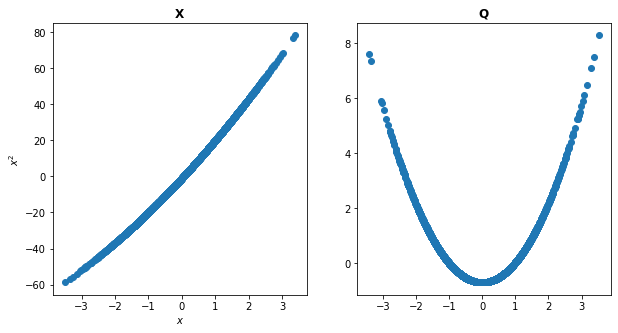

In [46]:
fig,axes=plt.subplots(1,2,figsize=(10,5))
X_sub=X-np.mean(X,axis=0)
axes[0].plot(X_sub[:,0],X_sub[:,1],'o')
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$x^2$')
axes[0].set_title('$\mathbf{X}$')
axes[1].plot(q[:,0],q[:,1],'o')
axes[1].set_title('$\mathbf{Q}$')

In [47]:
print(r'$\rho$ for X = {} , $\rho$ for q = {}'.format(np.corrcoef(X_sub.T)[0,1],np.corrcoef(q.T)[0,1]))

$\rho$ for X = 0.9976131840699471 , $\rho$ for q = -2.4163285672978022e-17


In [48]:
qr_cent_model="""

data {
  int<lower=0> N;   // number of data items
  int<lower=0> M;   // number of predictors
  matrix[M, N] X;   // predictor matrix
  vector[N] y;      // outcome vector
}
transformed data {
  matrix[N, M] Q_ast;
  matrix[M, M] R_ast;
  matrix[M, M] R_ast_inverse;
  matrix[M, N] X_centered;

  
   for (m in 1:M){
    X_centered[m] = X[m] - mean(X[m]);
    }
  // thin and scale the QR decomposition
  Q_ast = qr_thin_Q(X_centered') * sqrt(N - 1);
  R_ast = qr_thin_R(X_centered') / sqrt(N - 1);
  R_ast_inverse = inverse(R_ast);
}
parameters {
  real alpha;           // intercept
  vector[M] beta_tilde;      // coefficients on Q_ast
  real<lower=0> sigma;  // error scale
}

transformed parameters {
 vector[M] beta;
  beta = R_ast_inverse * beta_tilde; // coefficients on X
}
model {
  beta ~ normal(0, 10);
  alpha ~ normal(0, 10);
  sigma ~ cauchy(0, 10);
  y ~ normal(Q_ast * beta_tilde + alpha, sigma);  // liMelihood
}
"""

In [49]:
qr_cent_model=pystan.StanModel(model_code=qr_cent_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eaa219eeb8a1c9f1d836a8a33ac6c7c2 NOW.


In [50]:
fit_qr_cent=qr_cent_model.sampling(data=data,chains=4,iter=1000)

In [51]:
fit_qr_cent

Inference for Stan model: anon_model_eaa219eeb8a1c9f1d836a8a33ac6c7c2.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha         -76.19  2.9e-4   0.01 -76.21 -76.19 -76.19 -76.18 -76.16   1565    1.0
beta_tilde[1] -17.34  2.8e-4   0.01 -17.37 -17.35 -17.34 -17.33 -17.32   1680    1.0
beta_tilde[2]  -1.37  2.3e-4   0.01   -1.4  -1.38  -1.37  -1.37  -1.35   2653    1.0
sigma            0.8  1.6e-4 7.9e-3   0.78   0.79    0.8    0.8   0.81   2342    1.0
beta[1]         2.53  3.3e-3   0.17    2.2   2.41   2.53   2.64   2.86   2653    1.0
beta[2]         -1.0  1.7e-4 8.5e-3  -1.02  -1.01   -1.0  -0.99  -0.98   2653    1.0
lp__           -1407    0.04    1.4  -1410  -1408  -1406  -1406  -1405   1105    1.0

Samples were drawn using NUTS at Fri Jul 31 13:25:59 2020.
For each parameter, n_eff is a crude measure of effective sample size,
an

In [137]:
pystan.diagnostics.check_hmc_diagnostics(fit_qr)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [138]:
samp_params=fit_qr_cent.get_sampler_params(inc_warmup=False)

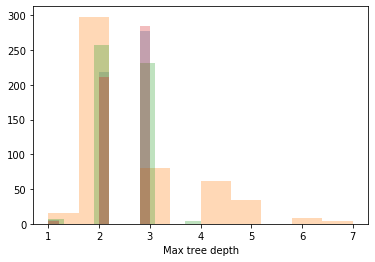

In [139]:
for i in range(0,4):
    plt.hist(samp_params[i]['treedepth__'],alpha=0.3)
plt.xlabel('Max tree depth');

In [140]:
for i in range(0,4):
    print('Number of gradient evaluations for chain '+str(i+1),samp_params[i]['n_leapfrog__'].sum())

Number of gradient evaluations for chain 1 2856.0
Number of gradient evaluations for chain 2 6390.0
Number of gradient evaluations for chain 3 2900.0
Number of gradient evaluations for chain 4 2814.0


A quarter of the number of evaluations

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
/opt/conda/lib/python3.7/site-packages/seabor

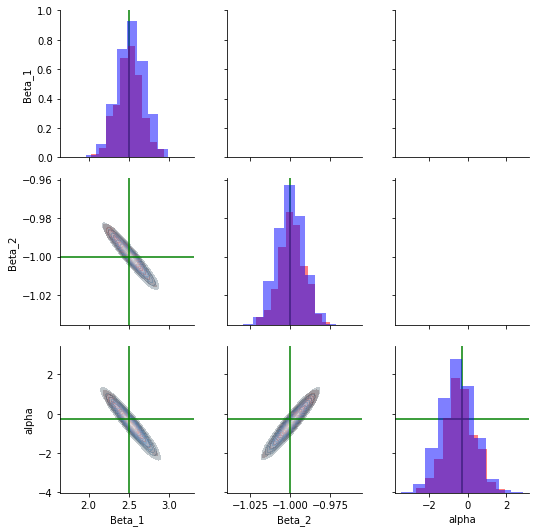

In [141]:
g=sns.PairGrid(pd.DataFrame(np.hstack((fit['beta'],fit['alpha'].reshape(2000,1))),columns=['Beta_1','Beta_2','alpha']))
g.map_lower(sns.kdeplot,shade=True,shade_lowest=False,cmap="Reds_d",alpha=0.3,n_levels=10,normed=True)
g.map_diag(plt.hist,color='red',alpha=0.5)
alpha_qr_cent=fit_qr_cent['alpha']-fit_qr_cent['beta'][:,0]*np.mean(X[:,0])-fit_qr_cent['beta'][:,1]*np.mean(X[:,1])
g.data=pd.DataFrame(np.hstack((fit_qr_cent['beta'],alpha_qr_cent.reshape(2000,1))),columns=['Beta_1','Beta_2','alpha'])
g.map_lower(sns.kdeplot,shade=True,shade_lowest=False,cmap="Blues_d",alpha=0.3,n_levels=10,normed=True)
g.map_diag(plt.hist,color='blue',alpha=0.5)

for i in range(0,3):
    for j in range(1,3):
        if (j>i) and (j<2):
            g.axes[j,i].axvline(beta[i,0],c='green')
            g.axes[j,i].axhline(beta[j,0],c='green')
        if j ==2:
            g.axes[j,i].axhline(alpha,c='green')
            if i < 2:
                g.axes[j,i].axvline(beta[i,0],c='green')
    if i<2:
        g.axes[i,i].axvline(beta[i,0],c='green')
    if i==2:
        g.axes[i,i].axvline(alpha,c='green')
    

Plotting the posterior for $\boldsymbol{\beta}$ and $\alpha$ for the original fit and our QR centered fit (and truth in green) we can see the fits are identical and recover the truth, but with QR and centering it is far more efficent

A good example of why this is working so well is if we look at the posterior for $\widetilde{\boldsymbol{\beta}}$, which shows no correlation.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


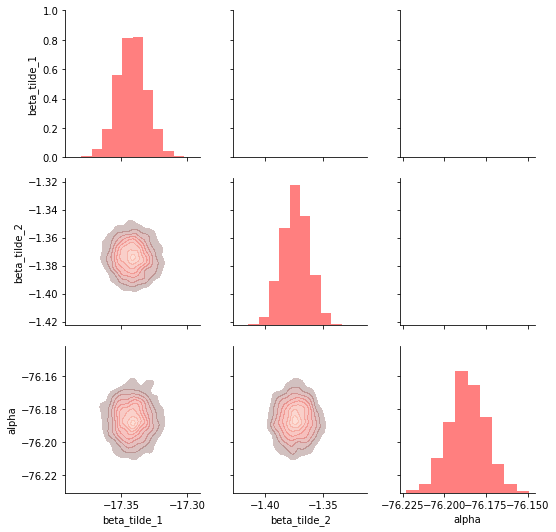

In [142]:
g=sns.PairGrid(pd.DataFrame(np.hstack((fit_qr_cent['beta_tilde'],fit_qr_cent['alpha'].reshape(2000,1))),columns=['beta_tilde_1','beta_tilde_2','alpha']))
g.map_lower(sns.kdeplot,shade=True,shade_lowest=False,cmap="Reds_d",alpha=0.3,n_levels=10,normed=True)
g.map_diag(plt.hist,color='red',alpha=0.5)